# IMPORT

In [1]:
# Model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR 

# Others
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

from training.train import train
from preprocessing.preprocessing import *
from dataset.thermal_dataset import thermal_dataset
from utils.csv_utils import *
from models.complete_model import complete_model
from models.lstm_only import lstm_only
from testing.test import test
prefix = '.'
    
pd.set_option('display.max_columns', None)

In [2]:
skip = False
test_flag = True
if os.path.exists(prefix+'/X.npy') and os.path.exists(prefix+'/Y.npy'):
    skip = True

**Reproducibility and Device Setting**

In [3]:
# Set a seed for reproducibility purposes
seed = 46
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Set the device (cuda for Nvidia GPUs, mps for M1, M2 .. Apple Silicon)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# DATASET

In [4]:

    # If skip is true, we simply load the data 
X = np.load(prefix+'/X.npy')
Y = np.load(prefix+'/Y.npy')

print(X)
print(Y)

[[21.41 21.69 21.67 21.64]
 [21.4  21.7  21.67 21.64]
 [21.42 21.71 21.68 21.65]
 ...
 [21.25 21.74 21.51 21.48]
 [21.25 21.72 21.5  21.5 ]
 [21.25 21.72 21.51 21.48]]
[[0.00509315 0.00554387 0.0203726 ]
 [0.00384014 0.00700421 0.02241587]
 [0.0026893  0.0071845  0.02394832]
 ...
 [0.00345252 0.00874099 0.00426683]
 [0.0033774  0.00869291 0.00363582]
 [0.0034976  0.00853365 0.00366587]]


In [5]:
def split(listToSplit, splitPercentages):
  length = len(listToSplit)
  splittedList = []
  lastIndex = 0
  for percentageIndex in range(len(splitPercentages)):
    print(lastIndex)
    splittedList.append(listToSplit[lastIndex:lastIndex+int(splitPercentages[percentageIndex]*length)])
    lastIndex += int(splitPercentages[percentageIndex]*length)

  return splittedList

In [6]:
splitPerc = [0.7,0.2,0.1]
splitted_X = split(X, splitPerc)
splitted_Y = split(Y, splitPerc)

0
21203
27261
0
21255
27328


# MODEL

In [7]:
hyper_parameters = {'num_epochs': 30,
                    'batch_size': 256,
                    'hidden_dim' : 3,
                    'lr': 0.000001,
                    'mode': 'auto-weighted', #average, mlp, linear, auto-weighted
                    'extractor_type': 'lstm', #lstm, rnn
                    'ensemble': True,
                    'timesteps': 170
                        }

ensemble_model = {'mlp': [{'layer_dim_list': [3,4,3]}],  
              'ARIMA': [{'p': 2, 'd': 0, 'q': 2, 'ps': 0, 'ds': 0, 'qs': 0, 's': 1}],
              'linear_regressor': [{'in_features': 3, 'out_features': 3}]
              }

ensemble_model1 = { 
              'ARIMA': [{'p': 2, 'd': 0, 'q': 2, 'ps': 0, 'ds': 0, 'qs': 0, 's': 1}],
              'linear_regressor': [{'in_features': 3, 'out_features': 3}, {'in_features': 3, 'out_features': 3}]
              }

ensemble_model2 = {
              'mlp': [{'layer_dim_list': [3,4,3]}],  
              'linear_regressor': [{'in_features': 3, 'out_features': 3}, {'in_features': 3, 'out_features': 3}]
              }
#1 ARIMA 2 linear
#1 MLP 2 linear
#
#tutti i voting

In [8]:
# Training, Test and Validation Dataloader initialization

loss_fn = nn.MSELoss()

# Test

In [75]:
train_val = False
# Need to specify a model.pt file to load! In the directory results that you want to test
result_path = '/results/training_2025-02-05_12-26'
model_path = prefix + result_path +'/model.pt'

# Read hyperparameters
with open (prefix + result_path + '/hyperparam.json', 'r') as f:
    hyperparams = json.load(f)
print(hyperparams)
if not 'window_size' in hyperparams.keys():
    hyperparams['window_size'] = 25

X = np.load(prefix+'/X'+str(hyperparams['window_size'])+'testing'+str(hyperparams['file'])+'.npy')
Y = np.load(prefix+'/Y'+str(hyperparams['window_size'])+'testing'+str(hyperparams['file'])+'.npy')
print('X',len(X))
print('Y',len(Y))
datasetTest = thermal_dataset((X,Y), hyperparams['timesteps'], device)
loaderTest = DataLoader(datasetTest, shuffle=True, batch_size=hyperparams['batch_size'])
# Section in which we reinitialize the model for testing depending on the hyperparameters.json and ensemble.json (if present) in the directories of results
# Read Ensemble models data (if complete = True)
if hyperparams['ensemble'] == True:
    # Read Ensemble model parameters and initialize the model
    with open (prefix + result_path + '/ensemble.json', 'r') as f:
        model_dict = json.load(f)
    model = complete_model(hidden_dim=hyperparams['hidden_dim'], input_dim=4, model_dict=model_dict, device=device, mode=hyperparams['mode'], extractor_type=hyperparams['extractor_type']).to(device)
# Otherwise create an LSTM only model
else:
    model = lstm_only(hidden_dim=hyperparams['hidden_dim'], timesteps=hyperparams['timesteps'] ,input_dim=4, output_dim=3).to(device)

model

test_metrics, test_loss_avg, total_inference_time, inference_time_avg, y_true_list, y_pred_list = test(
    model=model,
    model_path=model_path,
    test_dataloader=loaderTest,
    loss_fn=loss_fn,
    complete=hyperparams['ensemble']
)

print('Legend metrics:[X1,Y1,Z1]')
print("Test metrics:")
print(f"rmse: {test_metrics['rmse'][0]} , mae: {test_metrics['mae'][0]}, r2: {test_metrics['r2'][0]}")
print("Reference metrics(wrt. 0):")
print(f"rmse: {test_metrics['rmse_ref'][0]} , mae: {test_metrics['mae_ref'][0]}, r2: {test_metrics['r2_ref'][0]}")
print("Others:")
print(f"Average Loss: {test_loss_avg}, Total Inference Time (All Dataset): {total_inference_time}, Average Inference Time: {inference_time_avg}")


{'num_epochs': 30, 'batch_size': 256, 'hidden_dim': 60, 'lr': 0.001, 'mode': 'auto-weighted', 'extractor_type': 'lstm', 'ensemble': True, 'timesteps': 5, 'window_size': 25, 'file': 4}
X 3080
Y 3075
3
Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=60, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=3, bias=True)
    )
  )
  (1): linear(
    (linear_layer): Linear(in_features=60, out_features=3, bias=True)
  )
) ModuleList() ModuleList(
  (0): rnn(
    (rnn): RNN(60, 3, batch_first=True)
  )
)
loaded: ./results/training_2025-02-05_12-26/model.pt
Legend metrics:[X1,Y1,Z1]
Test metrics:
rmse: [0.006086400144881119, 0.007453049940311913, 0.00507415669895779] , mae: [0.004651007931075472, 0.006004335471754958, 0.003916789982963401], r2: [-4.388905955345362, -1.426026895283679, -0.37367945668062097]
Reference metrics(wrt. 0):
rmse: [0.0026219490262328355, 0.00478582314154823, 0.004503732398746331] , mae: 

/home/paolo/uni/magistrale/Napoli/eai-project/models/complete_model.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.dev

In [76]:
if train_val:
    path = prefix + result_path  # type ./results/ensemble_batch_256

    # Load the dictionaries
    with open (path + '/train_metrics.json', 'r') as f:
        train_metrics = json.load(f)
    with open (path + '/valid_metrics.json', 'r') as f:
        valid_metrics = json.load(f)

    # Initialize a list of epochs [1,2,3, ...] for the plots x-axis
    epochs = [i for i in range(1, hyperparams['num_epochs']+1)]

    # Compute training loss as the square of rmse for each element because loss = mse
    # Both for training and validation
    training_loss = [rmse**2 for rmse in train_metrics['rmse']] 
    valid_loss = [rmse**2 for rmse in valid_metrics['rmse']] 

    plt.plot(epochs, training_loss, label='Training', color='b')
    plt.plot(epochs, valid_loss, label='Validation', color='r')
    plt.title('Loss (RMSE^2)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss value')
    plt.legend()

    plt.tight_layout()  # This helps to prevent overlapping of subplots
    plt.savefig(path+'/loss')  # Save the figure to the specified path
    plt.show()

In [77]:
if train_val:
    path = prefix + result_path  # type ./results/ensemble_batch_256

    # Load the dictionaries
    with open (path + '/train_metrics.json', 'r') as f:
        train_metrics = json.load(f)
    with open (path + '/valid_metrics.json', 'r') as f:
        valid_metrics = json.load(f)

    # Initialize a list of epochs [1,2,3, ...] for the plots x-axis
    epochs = [i for i in range(1, hyperparams['num_epochs']+1)]

    plt.plot(epochs, train_metrics['mae'], label='Training', color='b')
    plt.plot(epochs, valid_metrics['mae'], label='Validation', color='r')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE value')
    plt.legend()

    plt.tight_layout()  # This helps to prevent overlapping of subplots
    plt.savefig(path + '/mae')  # Save the figure to the specified path
    plt.show()

In [78]:
if train_val:
    path = prefix + result_path  # type ./results/ensemble_batch_256

    # Load the dictionaries
    with open (path + '/train_metrics.json', 'r') as f:
        train_metrics = json.load(f)
    with open (path + '/valid_metrics.json', 'r') as f:
        valid_metrics = json.load(f)

    # Initialize a list of epochs [1,2,3, ...] for the plots x-axis
    epochs = [i for i in range(1, hyperparams['num_epochs']+1)]

    plt.plot(epochs, train_metrics['r2'], label='Training', color='b')
    plt.plot(epochs, valid_metrics['r2'], label='Validation', color='r')
    plt.title('R2 (Coefficient of determination)')
    plt.xlabel('Epochs')
    plt.ylabel('R2 value')
    plt.legend()

    plt.tight_layout()  # This helps to prevent overlapping of subplots
    plt.savefig(path + '/r2')  # Save the figure to the specified path
    plt.show()

In [79]:
path = prefix + result_path

# Create the lists of X1, Y1, Z1 true values to plot
x1_true = [x[0] for x in y_true_list]
y1_true = [y[1] for y in y_true_list]
z1_true = [z[2] for z in y_true_list]

# Create the lists of X1, Y1, Z1 predicted values to plot
x1_pred = [x[0] for x in y_pred_list]
y1_pred = [y[1] for y in y_pred_list]
z1_pred = [z[2] for z in y_pred_list]

# Create x-axis
t = [i for i in range(1, len(y_pred_list)+1)]


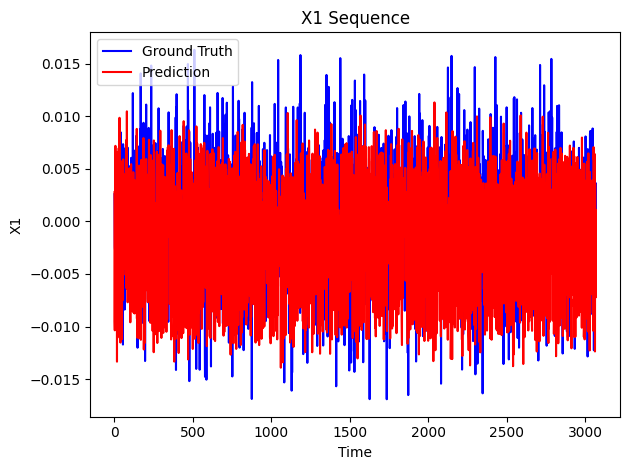

In [80]:
# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
#t = [i for i in range(1, len(Y[:,0])+1)]
plt.plot(t, y1_true, label='Ground Truth', color='b')
plt.plot(t, x1_pred, label='Prediction', color='r')
plt.title('X1 Sequence')
plt.xlabel('Time')
plt.ylabel('X1')
plt.legend()

plt.tight_layout()  # This helps to prevent overlapping of subplots
plt.savefig(path + '/X1')  # Save the figure to the specified path
plt.show()

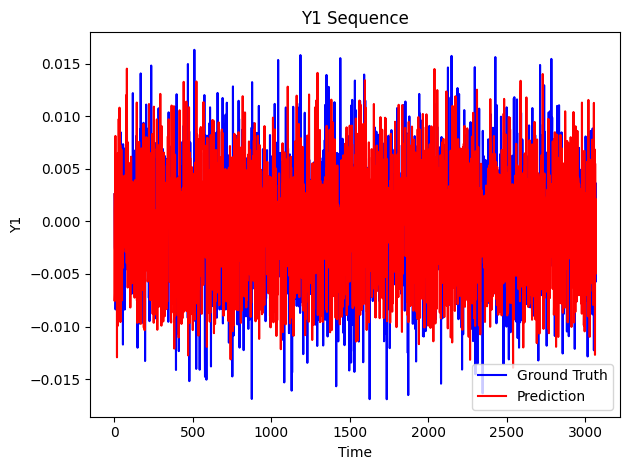

In [81]:
# Initialize a list of epochs [1,2,3, ...] for the plots x-axis

plt.plot(t, y1_true, label='Ground Truth', color='b')
plt.plot(t, y1_pred, label='Prediction', color='r')
plt.title('Y1 Sequence')
plt.xlabel('Time')
plt.ylabel('Y1')
plt.legend()

plt.tight_layout()  # This helps to prevent overlapping of subplots
plt.savefig(path + '/Y1')  # Save the figure to the specified path
plt.show()

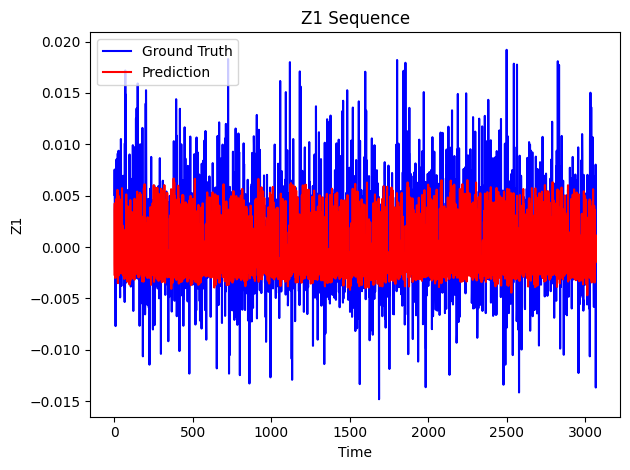

In [82]:
# Initialize a list of epochs [1,2,3, ...] for the plots x-axis

plt.plot(t, z1_true, label='Ground Truth', color='b')
plt.plot(t, z1_pred, label='Prediction', color='r')
plt.title('Z1 Sequence')
plt.xlabel('Time')
plt.ylabel('Z1')
plt.legend()

plt.tight_layout()  # This helps to prevent overlapping of subplots
plt.savefig(path + '/Z1')  # Save the figure to the specified path
plt.show()